#### Setup

In [1]:
!pip install psycopg2-binary psycopg sqlalchemy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 kB 14.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sqlalchemy import create_engine, text

In [ ]:
db_user = "avnadmin"
db_pass = "AVNS_"
db_host = "pg-79721e--a763.j.aivencloud.com"
db_port = "1022"
db_name = "tatu_city_calls"

ssl_cert_path = "ca.pem"

In [4]:
DATABASE_URL=f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}?sslmode=verify-full&sslrootcert={ssl_cert_path}"


In [5]:
engine = create_engine(DATABASE_URL)

In [8]:
# combined_calls = pd.read_csv("combined_calls.csv")
# display(combined_calls.head())
# combined_calls.shape[0]


### Send to DB HOSTED IN AIVEN

In [ ]:
#prepare the combined call and send it to the postgres db
combined_calls.to_sql("combined_calls", engine, if_exists="replace", method="multi" , index=False)

In [ ]:
# #create replica table for staging, called combined_calls_stagging, create from the sqltable not dataframe
# with engine.connect() as conn:
#     conn.execute(text("""
#         CREATE TABLE combined_calls_staging AS
#         SELECT * FROM combined_calls;
#     """))
#     conn.commit()





### TEST CONNECTON

In [9]:
total_records = """
SELECT COUNT(*) AS total_records
FROM combined_calls;
"""

pd.read_sql(total_records, engine)

,total_records
0,942486


### PART A

#### 2) How many unique users are there?

In [10]:
#query distinct users from the staging table
distinct_users = """
SELECT COUNT(DISTINCT "UserId") AS unique_users
FROM combined_calls;
"""

pd.read_sql(distinct_users, engine)



,unique_users
0,673


#### 3) Who are the top 10 users who took calls? How many calls did each take?

In [11]:
top_ten_users = """
SELECT "UserId", COUNT(*) AS call_count
FROM combined_calls
GROUP BY "UserId"
ORDER BY call_count DESC
LIMIT 10;
"""

pd.read_sql(top_ten_users, engine)

,UserId,call_count
0,c4580193-23d1-4a28-aebb-136c27848142,8402
1,58eea8b2-12ef-4e44-b229-af25799ac3bb,8135
2,b8b5a757-7176-499d-b93d-8feebb36c09f,7351
3,4ff996ef-9f41-4fc7-9894-333cd0364bcc,7116
4,bed34990-b428-4868-b4b3-e18e0980dedf,6836
5,8261bb15-26ea-48f4-b5e8-686de8c5ccea,6601
6,57fe1954-e706-4ac9-a693-8f0d8b5faa5d,6536
7,fefd5888-a8c0-4c46-8061-81b2e104efb0,6383
8,5933760a-c198-489e-b828-0a95aaa66edb,6217
9,96591502-f4f9-4357-b7ca-11fed55b1fc3,6181


#### 4) What is the average total handle time of a call?

In [12]:
#average total handle time for a call
average_handle_time = """
SELECT AVG("Total_Handle_Time") AS average_handle_time
FROM combined_calls;
"""

pd.read_sql(average_handle_time, engine)

,average_handle_time
0,1180.874913


#### 5) Who are the top 10 users with the highest ratio of disconnect type ‘peer’ to total calls taken? What is the ratio for each of these users? How does this differ from disconnects ‘client’ and ‘peer’? What can you infer from this?

In [13]:
#top10 users users with high ratio peer disconnect type to total calls taken, and the ratio for each user

top_ten_peer_disconnect = """
SELECT "UserId",
       COUNT(*) AS total_calls,
       SUM(CASE WHEN "disconnectType" = 'peer'  THEN 1 ELSE 0 END) AS peer_disconnect_count,
       (SUM(CASE WHEN "disconnectType" = 'peer'  THEN 1 ELSE 0 END) / COUNT(*)) AS ratio
FROM combined_calls
GROUP BY "UserId"
ORDER BY ratio DESC
LIMIT 10;
"""

pd.read_sql(top_ten_peer_disconnect, engine)


,UserId,total_calls,peer_disconnect_count,ratio
0,955420c8-5bac-44e4-aee6-4ee3290ee951,1,1,1
1,a79aadd2-7c79-44e4-b91a-32c7877e7451,1,1,1
2,3efc1723-40ca-4c5d-8632-3a68fbf098ec,2,2,1
3,73b0cfbe-b3a7-485d-8e1d-bebda414c7f4,1,1,1
4,96def154-5dad-4e55-90f8-5a08b75178fa,3,3,1
5,a2e4de56-ef35-4c3b-96a7-3adf431f7ab8,1,1,1
6,02c55e34-065c-4c3b-91dc-8101df456057,1,1,1
7,09891927-925e-42c1-afe1-c931912b0acc,1,1,1
8,63b05569-e426-4221-b7b0-82ef54b7e13d,2,2,1
9,ad7f05c7-8eed-4ed5-9538-04fbf3bf0fff,1,1,1


Every call taken by these users was disconnected by a peer.

#### 6) How many inbound queue calls were received per month?

In [14]:
#inbound_queue calls per month


inbound_queue_calls = """

  SELECT
    EXTRACT(YEAR FROM "StartDateTime"::timestamp) AS year,
    EXTRACT(MONTH FROM "StartDateTime"::timestamp) AS month,
    COUNT(*) AS total_inbound_queue_calls
FROM combined_calls
WHERE "CallType" = 'Inbound_Queue'

GROUP BY year, month
ORDER BY year, month;
"""

pd.read_sql(inbound_queue_calls, engine)










,year,month,total_inbound_queue_calls
0,2023.0,1.0,57871
1,2023.0,2.0,52043
2,2023.0,3.0,54822
3,2023.0,4.0,49935
4,2023.0,5.0,47810
5,2023.0,6.0,43944
6,2023.0,7.0,41282
7,2023.0,8.0,39631
8,2023.0,9.0,33387
9,2023.0,10.0,31991


#### 7) What is the percentage difference of inbound queue calls taken in 2023 vs 2024?

In [15]:
inbound_queue_calls_year_percentage_difference = """
WITH yearly_totals AS (
    SELECT
        EXTRACT(YEAR FROM "StartDateTime"::timestamp) AS year,
        COUNT(*) AS total_calls
    FROM combined_calls
    WHERE "CallType" = 'Inbound_Queue'
    GROUP BY year
)
SELECT
    (
        (SELECT total_calls FROM yearly_totals WHERE year = 2024)
        -
        (SELECT total_calls FROM yearly_totals WHERE year = 2023)
    ) * 100.0
    /
    (SELECT total_calls FROM yearly_totals WHERE year = 2023)
    AS percentage_difference_2024_vs_2023;
"""
pd.read_sql(inbound_queue_calls_year_percentage_difference, engine)



,percentage_difference_2024_vs_2023
0,-13.055561


the volume of inbound queue calls has dropped slightly (by 13%) compared to the previous year.

#### 8) What is the month and year with the most inbound queue calls?

In [16]:
#month and year with the most inboundcalls

Highest_inbound_queue_calls = """
  SELECT
    TO_CHAR("StartDateTime"::timestamp, 'YYYY-MM') AS month_year,
    COUNT(*) AS total_calls
FROM combined_calls
WHERE "CallType" = 'Inbound_Queue'
GROUP BY month_year
ORDER BY total_calls DESC
LIMIT 1;

"""
pd.read_sql(Highest_inbound_queue_calls, engine)

,month_year,total_calls
0,2024-06,64038


### PART B

#### 9) How many calls were taken per month during 2023 and 2024?


In [17]:

query_monthly_calls = """
SELECT
    TO_CHAR("StartDateTime"::timestamp, 'YYYY-MM') AS month_year,
    COUNT(*) AS total_calls
FROM combined_calls
WHERE "CallType" = 'Inbound_Queue'
GROUP BY month_year
ORDER BY month_year;
"""

monthly_calls = pd.read_sql(query_monthly_calls, engine)
monthly_calls['month_year'] = pd.to_datetime(monthly_calls['month_year'])
monthly_calls.set_index('month_year', inplace=True)
monthly_calls = monthly_calls.asfreq('MS')
monthly_calls


,total_calls
month_year,
2023-01-01,57871
2023-02-01,52043
2023-03-01,54822
2023-04-01,49935
2023-05-01,47810
2023-06-01,43944
2023-07-01,41282
2023-08-01,39631
2023-09-01,33387


#### 10) What is the forecasted call count per month in 2025 and 2026?

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    monthly_calls['total_calls'],
    trend='add',   # additive trend
    seasonal='add', # additive seasonality
    seasonal_periods=12
).fit()

# Forecast next 24 months (2025 & 2026)
forecast = model.forecast(24)
forecast.index = pd.date_range(start='2025-01-01', periods=24, freq='MS')
forecast

,0
2025-01-01,36543.836657
2025-02-01,34316.372340
2025-03-01,37575.070744
2025-04-01,37591.245942
2025-05-01,34823.233991
2025-06-01,62157.213907
2025-07-01,34506.537189
2025-08-01,34169.559848
2025-09-01,29095.001978
2025-10-01,28641.836061


#### 11) What model was used to build the forecast?

Holt-Winters Exponential Smoothing (ETS) with additive trend and seasonality.



#### 12) Why did you choose this model?

- It captures both trend and seasonality, which is typical for monthly call volumes (calls can have peaks during certain months).

- Works well for short to medium-term forecasts.

#### 13) Paste the visualization of the actual data and forecast.

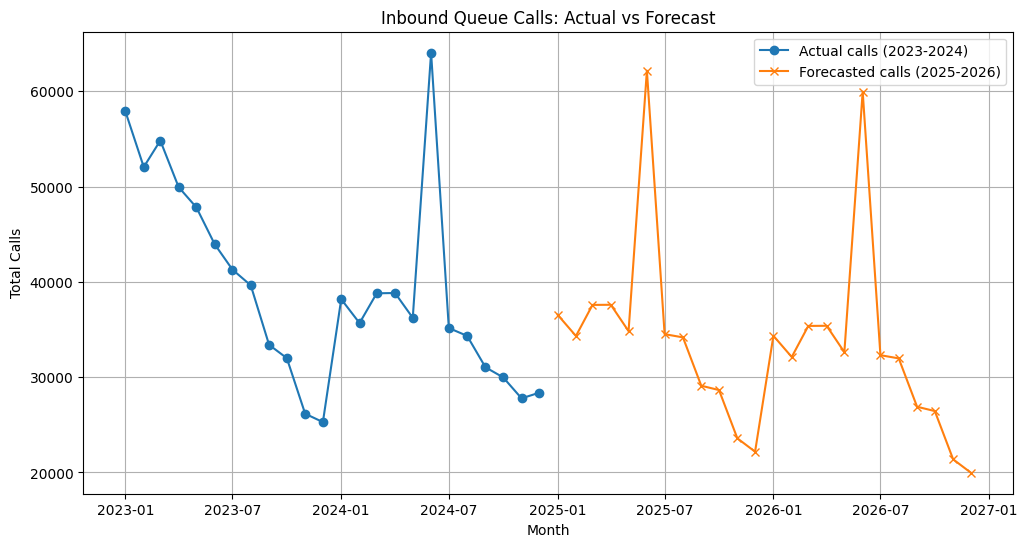

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(12,6))
plt.plot(monthly_calls['total_calls'], label='Actual calls (2023-2024)', marker='o')
plt.plot(forecast, label='Forecasted calls (2025-2026)', marker='x')
plt.title('Inbound Queue Calls: Actual vs Forecast')
plt.xlabel('Month')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.show()

#Part C

#### 14) Is there a correlation between hold time and handle time?

In [20]:
df_query = """

SELECT
    "Total_Hold_Time",
    "Total_Handle_Time",
    "Total_Talk_Time",
    "Total_Survey",
    "disconnectType"
FROM combined_calls;
"""

# StartDateTime	UserId	CallType	disconnectType	Total_Handle_Time	Total_Hold_Time	Total_Talk_Time	Total_Survey	Average of Average_Survey

df_calls = pd.read_sql(df_query, engine)




correlation_hold_handle = df_calls['Total_Hold_Time'].corr(df_calls['Total_Handle_Time'])
correlation_hold_handle

np.float64(0.7524607254506358)

Yes, A correlation of ~0.75 indicates a strong positive linear relationship.

#### 15) How is talk time affected by hold time?

A correlation of ~0.75 indicates a strong positive linear relationship. This means, that as hold time increases handle time also tends to increase

#### 16) Is there a correlation between survey scores and disconnect type?

In [21]:
df_calls['Total_Survey'] = (
    df_calls['Total_Survey']
    .astype(str)
    .str.strip()
)

df_calls['Total_Survey'] = pd.to_numeric(
    df_calls['Total_Survey'],
    errors='coerce'
)

survey_by_disconnect = df_calls.groupby('disconnectType')['Total_Survey'].mean()
survey_by_disconnect


,Total_Survey
disconnectType,
client,9.621363
conferenceTransfer,10.000000
endpoint,5.308076
error,6.000000
nan,8.058824
peer,9.514531
transfer,9.524897


There is a clear association between survey scores and disconnect type. Managed disconnects such as conference transfers and standard transfers achieve the highest satisfaction scores, while technical failures (endpoint and error disconnects) result in significantly lower customer satisfaction. This indicates that disconnect type is a meaningful driver of customer experience.

#### 17) Is there a correlation between hold time and disconnect type? If so, please explain it.

In [22]:
hold_by_disconnect = df_calls.groupby('disconnectType')['Total_Hold_Time'].mean()
hold_by_disconnect

,Total_Hold_Time
disconnectType,
client,250.777376
conferenceTransfer,591.772708
endpoint,187.511354
error,371.551897
nan,159.890830
peer,227.768654
transfer,323.818411


Hold time varies meaningfully by disconnect type. Longer hold times are associated with conference transfers and error-related disconnects, while shorter hold times are observed in endpoint failures. This suggests that prolonged waiting increases call complexity and the risk of undesirable outcomes.